# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import inspect
%matplotlib inline

## Setup for demo
Demo images and helper function that I implemented to support showing (and testing) various steps in the image processing implementation. Note that this is achieved without getting the output from the video processing loop too messed up and slowed down.

In [2]:
import os
demo_images = []
demo_names = []
for file in os.listdir("test_images/"):
    demo_images.append(mpimg.imread('test_images/' + file))
    demo_names.append(os.path.splitext(file)[0])

num_demo_images = len(demo_images)

# The implementation shows partial image processing results when demo_mode is True, 
# it will be set to False before the final processing loop in the end.
demo_mode = True  

fig_cols = 2
fig_rows = num_demo_images / fig_cols
fig_dict = {}

def demo_show(image, title='', cmap=None, lines=None):
    if demo_mode:
        # Use callstack to get a unique dictionary key for this calling line
        caller = inspect.getframeinfo(inspect.stack()[1][0])
        fig_key = caller.filename + str(caller.lineno)
        
        # Check if there already is a figure for this caller
        if fig_key in fig_dict:
            fig, fig_idx = fig_dict[fig_key]
            plt.figure(fig.number)
        else:
            fig = plt.figure(figsize=(15, 15))
            fig.suptitle(title, fontsize=16, y=0.9)
            fig_idx = 0
        
        if lines is not None:
            plt_image = np.copy(image)  # Create a copy that can be modified before imshow 
            draw_lines(plt_image, lines, color=[255, 0, 0], thickness=2)
        else:
            # Image will not be alternated so just reference input
            plt_image = image  
        
        fig_idx += 1
        ax = plt.subplot(fig_rows, fig_cols, fig_idx)
        ax.axis('off')
        ax.set_title(demo_names[fig_idx - 1])
        ax.imshow(plt_image, cmap=cmap)
        
        fig_dict[fig_key] = (fig, fig_idx)
        if fig_idx == num_demo_images:
            # Clean up the dictionary mainly to make it possible to run the same demo twice, 
            # without having to re-run this demo setup cell.
            del fig_dict[fig_key]
            
        if not fig_dict:
            # All figures are ready, lets show'em
            plt.show()


## Build a Lane Finding Pipeline



### Helper functions
Functions provided by Udacity, I only keeped the ones that I ended up using.

In [3]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


### Region of interest
The region of interest used to mask out areas in the image where lane lines not are expected. This is just a constant area for now, but it would probably be a good idea trying to make it dynamic in some way.

In [4]:
# Common definition of ROI vertices, used both for color and edge based line detections
def get_ROI_vertices(image):
    return np.array([[(50, image.shape[0]), (460, image.shape[0] - 250), (image.shape[1] - 460, image.shape[0] - 250),
                      (image.shape[1] - 50, image.shape[0])]], dtype=np.int32)

#### Demo

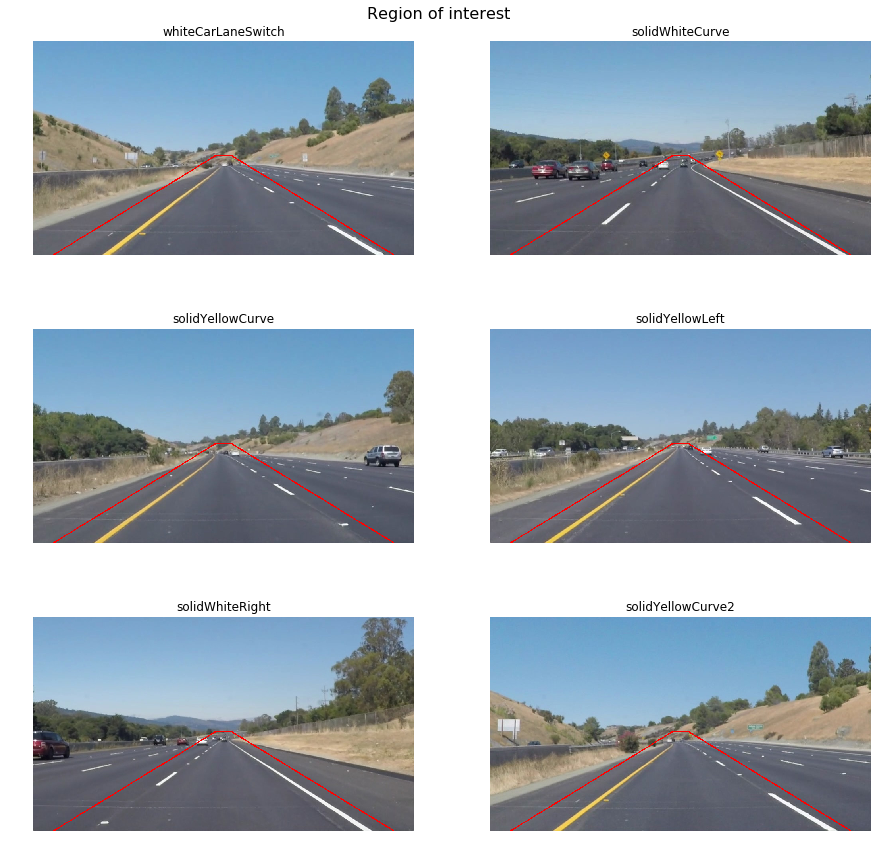

In [5]:
for image in demo_images:
    vertices = get_ROI_vertices(image)
    lines = []
        
    prev_point = vertices[0][-1] 
    for current_point in vertices[0]:
        line = [prev_point[0], prev_point[1], current_point[0], current_point[1]]
        lines.append(line)
        prev_point = current_point
    
    lines = np.array([lines])
    demo_show(image, title="Region of interest", lines=lines)
    

### Find lines by edge extraction

Use canny edge detector and hough tranform to detect raw line segments 

In [6]:
def find_lines_by_edges(image):
    demo_show(image, title='RGB input')
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    demo_show(gray, title='Gray scale', cmap='gray')
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

    demo_show(blur_gray, title='GaussianBlur', cmap='gray')
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    demo_show(edges, title='Canny edge', cmap='gray')
    
    # Apply ROI masking
    masked_edges = region_of_interest(edges, get_ROI_vertices(edges))
    demo_show(masked_edges, title='ROI masked', cmap='gray')

    # Define the Hough transform parameters
    rho = 2  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 40  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20   # minimum number of pixels making up a line
    max_line_gap = 7  # maximum gap in pixels between connectible line segments

    lines = cv2.HoughLinesP(masked_edges, rho=rho, theta=theta, threshold=threshold,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)

    demo_show(image, title='Raw hough line segments', lines=lines)
    return lines

#### Demo

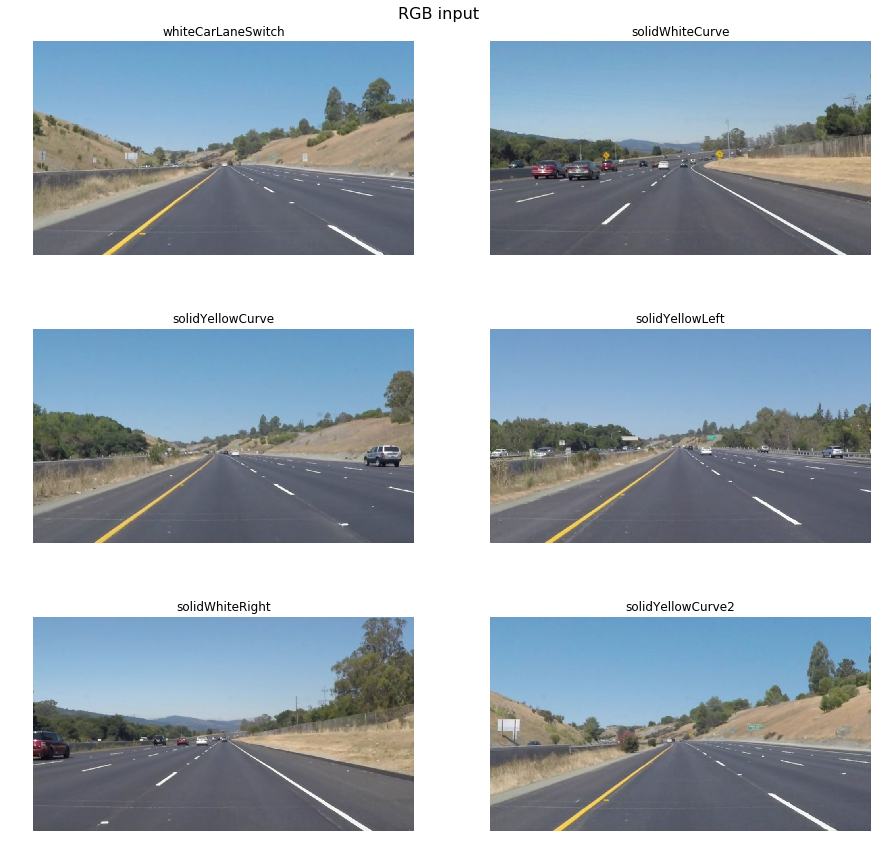

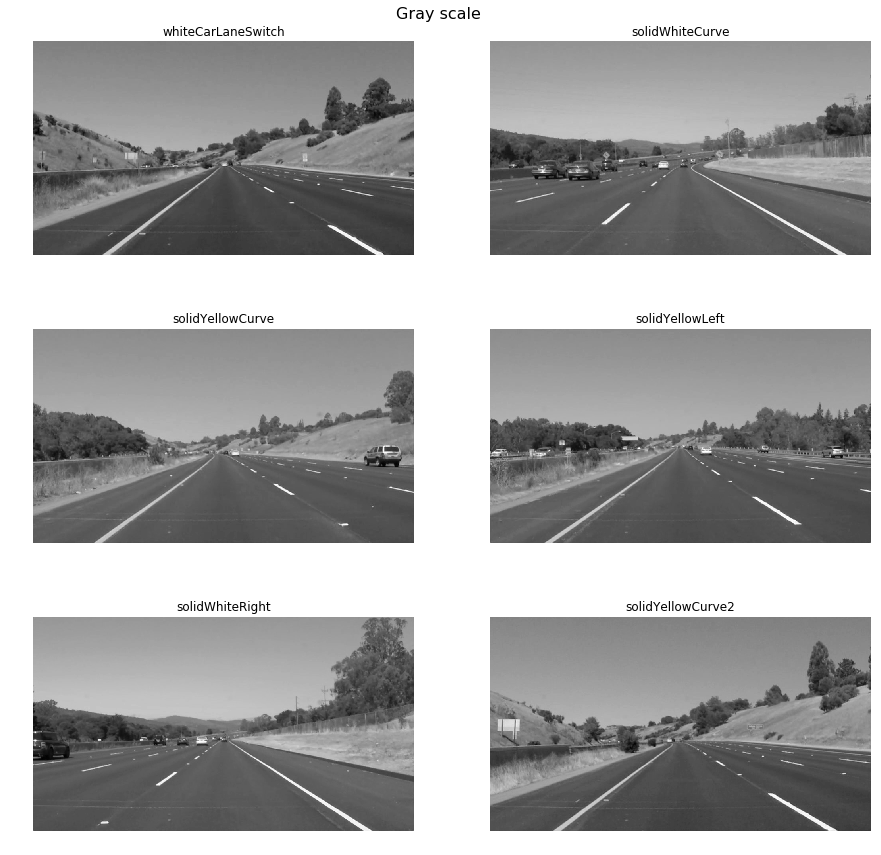

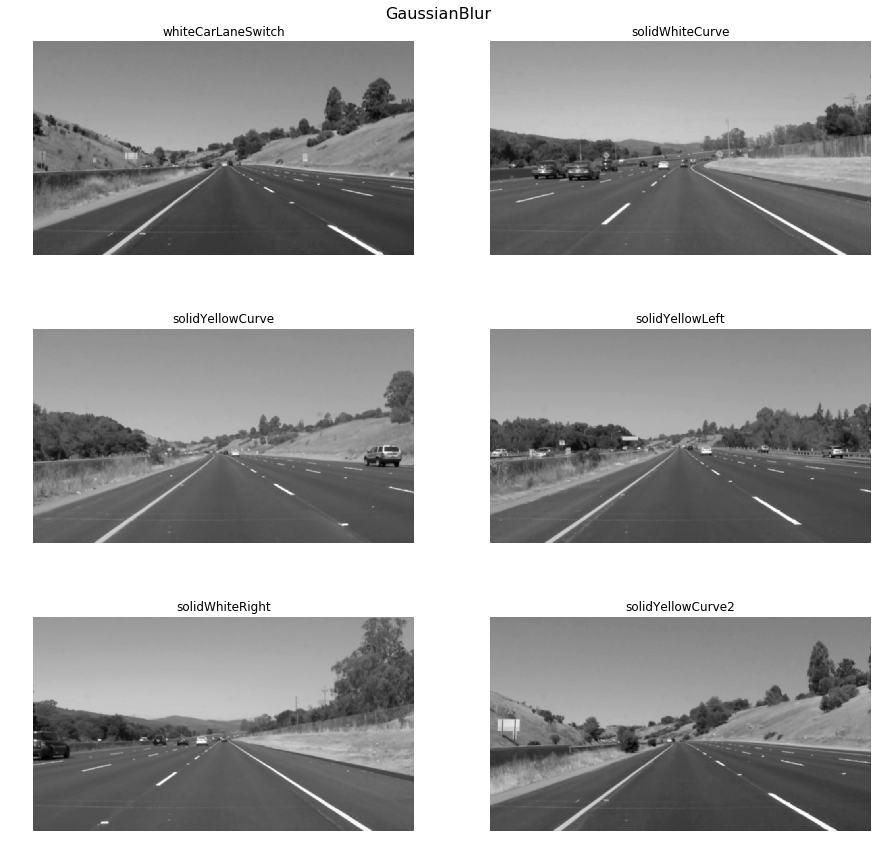

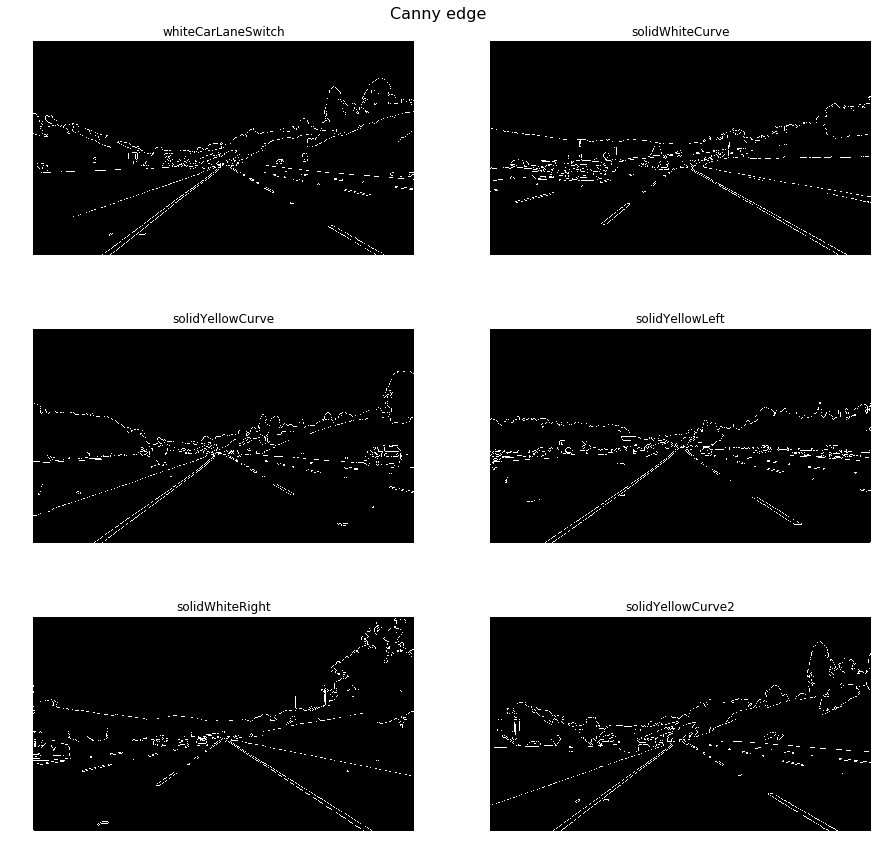

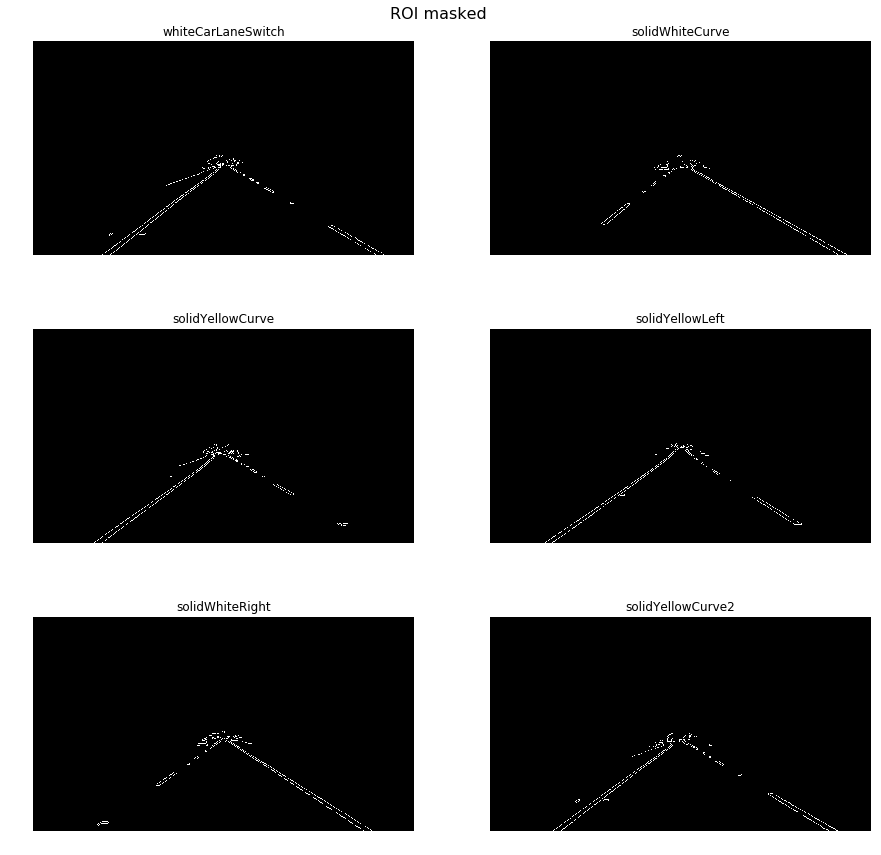

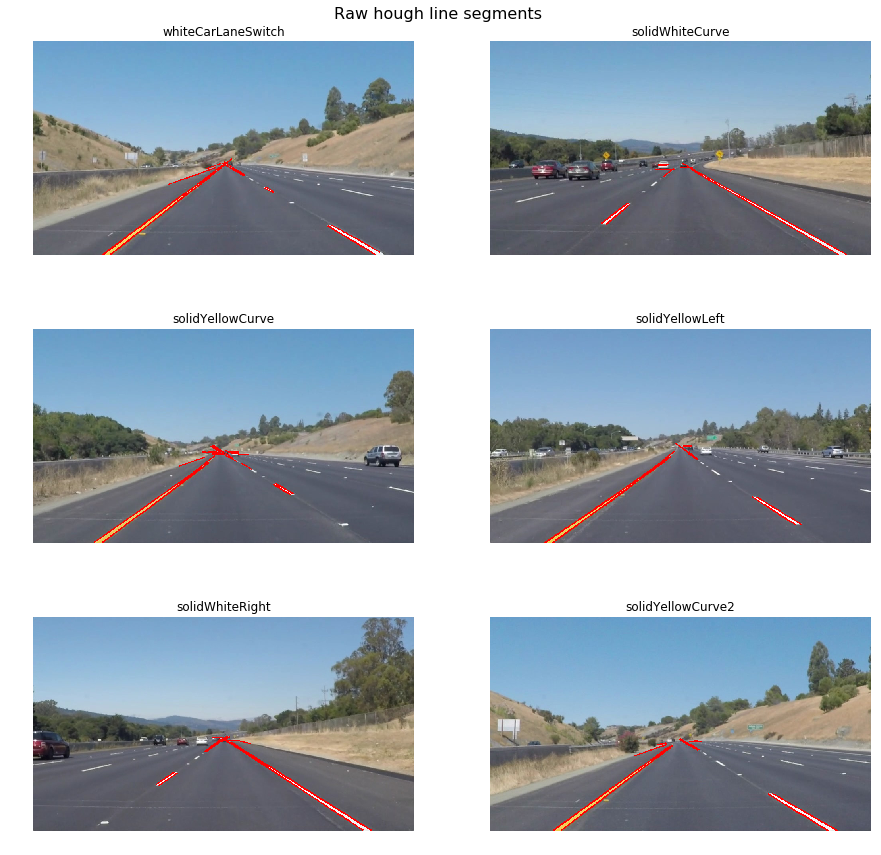

In [7]:
# Show the steps in the edge based raw line segments extraction
demo_edge_lines = []
for image in demo_images:
    demo_edge_lines.append(find_lines_by_edges(image))


### Find lines by color

Color thresholding to detect white and yellow foreground objects, then do some morphological operations to reduce noise and get a skeletonized representation of the forground objects. The hough transform is then used to extract line segments.

In [8]:
def color_threshold_yellow(hsv_image):
    hsv_lower_th = np.array([20, 70, 120])
    hsv_upper_th = np.array([25, 255, 245])
    mask = cv2.inRange(hsv_image, hsv_lower_th, hsv_upper_th)
    return mask


def color_threshold_white(hsv_image):
    hsv_lower_th = np.array([0, 0, 240])
    hsv_upper_th = np.array([255, 255, 255])
    mask = cv2.inRange(hsv_image, hsv_lower_th, hsv_upper_th)
    return mask


# Use morphological operations to remove some noise from a binary image
def remove_noise(binary_image):

    # Fix small holes in foreground object with morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    output_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

    # I also evaluated different kernels for removing small foreground objects using morphological
    # opening, but with bad result on the lane lines.

    return output_image


# Use morphological operations to reduce foreground objects until only the skeleton remains
def skeletonize(binary_image):
    size = np.size(binary_image)
    skel_image = np.zeros(binary_image.shape, np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

    while True:
        eroded = cv2.erode(binary_image, kernel)
        temp = cv2.dilate(eroded, kernel)
        temp = cv2.subtract(binary_image, temp)
        skel_image = cv2.bitwise_or(skel_image, temp)
        binary_image = eroded.copy()

        # Repeat until the binary image operations above have no more effect
        zeros = size - cv2.countNonZero(binary_image)
        if zeros == size:
            break

    return skel_image


def find_lines_by_colors(rgb_image):
    demo_show(rgb_image, title='RGB input')
    
    # Convert the RGB image to HSV to make color thresholding a little bit more robust, or at least easier.
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    demo_show(hsv_image, title='HSV, displayed using RGB cmap')
    
    # Threshold the image for yellow and white
    yellow_mask = color_threshold_yellow(hsv_image)
    demo_show(yellow_mask, title='Yellow threshold mask', cmap='gray')
    white_mask = color_threshold_white(hsv_image)
    demo_show(white_mask, title='White threshold mask', cmap='gray')

    # Combine the yellow and white binary images
    lines_mask = cv2.bitwise_or(yellow_mask, white_mask)
    demo_show(lines_mask, title='Yellow + white mask', cmap='gray')

    # Clear everything but region of interest
    roi_lines_mask = region_of_interest(lines_mask, get_ROI_vertices(lines_mask))
    demo_show(roi_lines_mask, title='ROI masked', cmap='gray')
    
    # Remove some holes in detected lines
    filered_mask = remove_noise(roi_lines_mask)
    demo_show(filered_mask, title='Morphological closed', cmap='gray')
    
    # Reduce detected lines into just a skeleton
    skeleton_image = skeletonize(filered_mask)
    demo_show(skeleton_image, title='Skeletonized', cmap='gray')
    
    # Define the Hough transform parameters
    rho = 2  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 40  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20  # minimum number of pixels making up a line
    max_line_gap = 10  # maximum gap in pixels between connectible line segments

    lines = cv2.HoughLinesP(skeleton_image, rho=rho, theta=theta, threshold=threshold,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    demo_show(rgb_image, title='Raw hough line segments', lines=lines)
    
    return lines

#### Demo

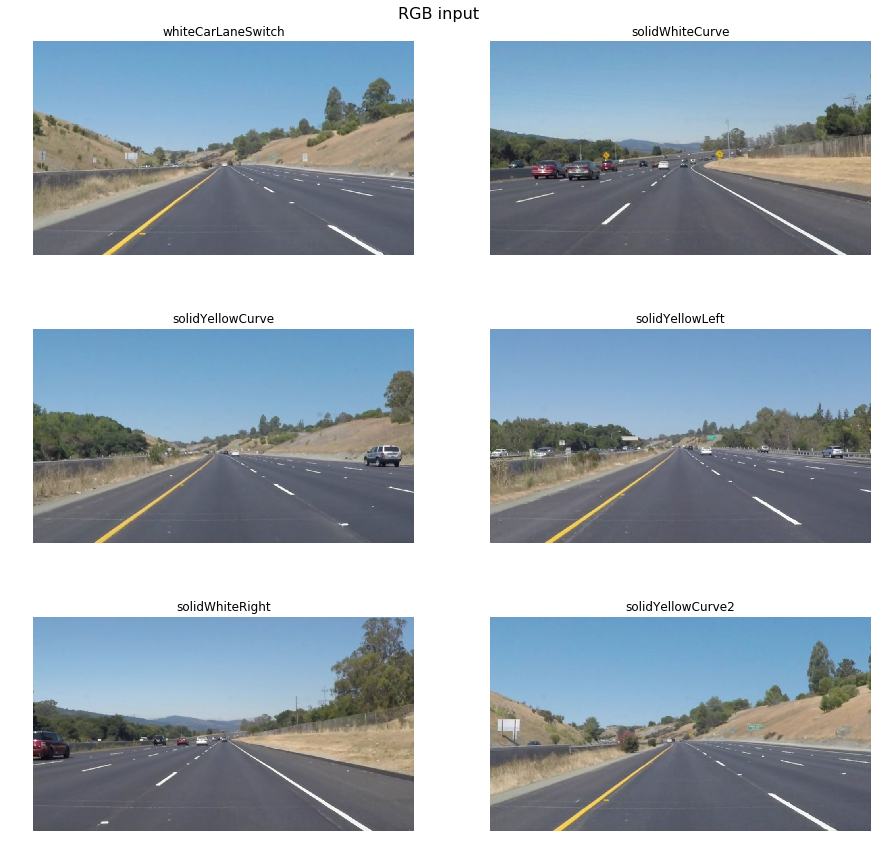

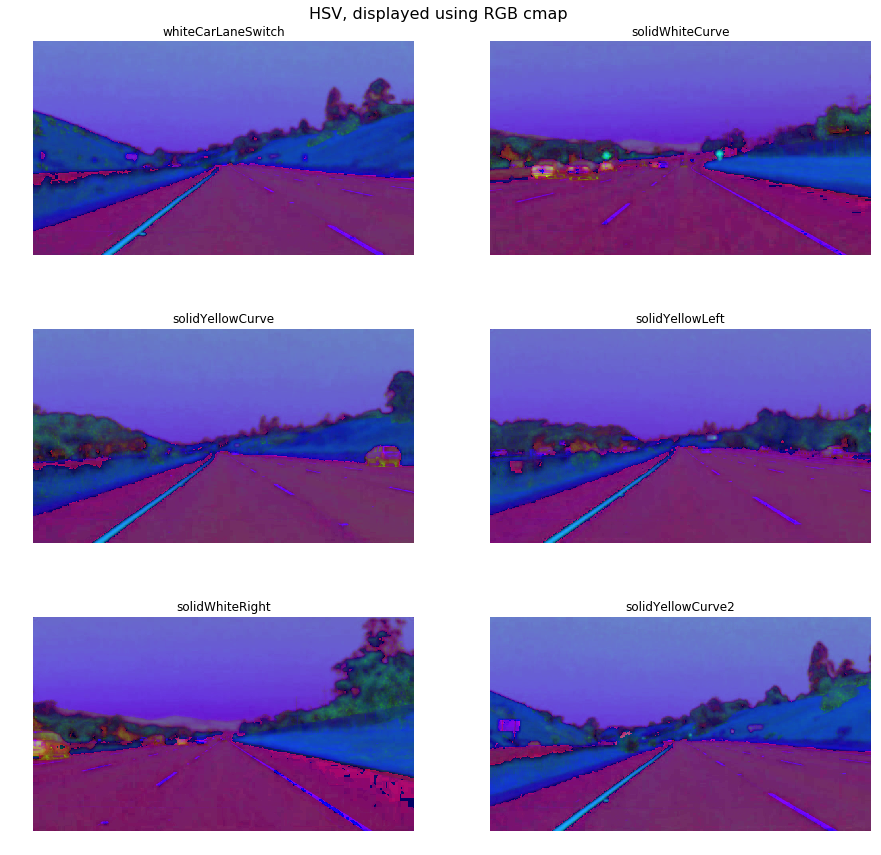

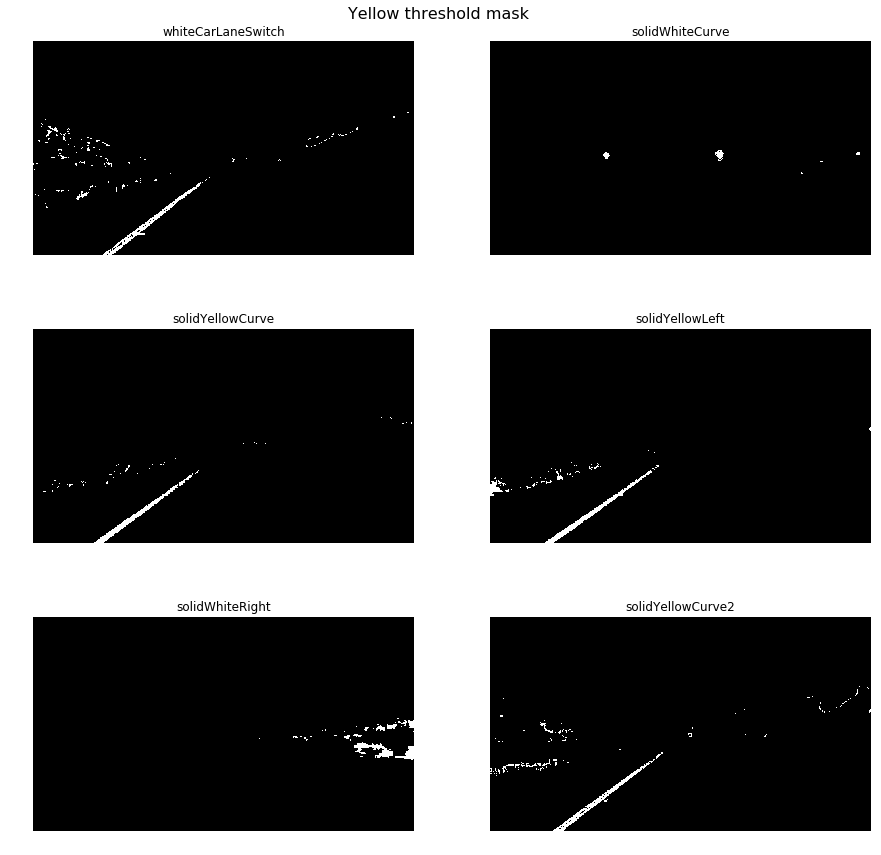

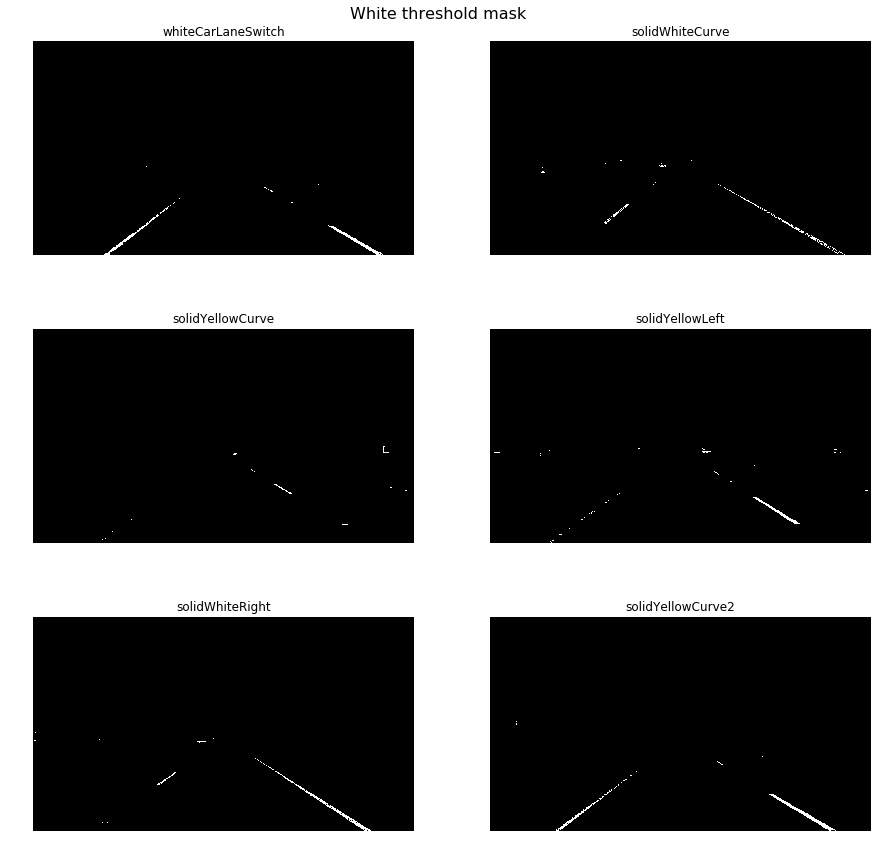

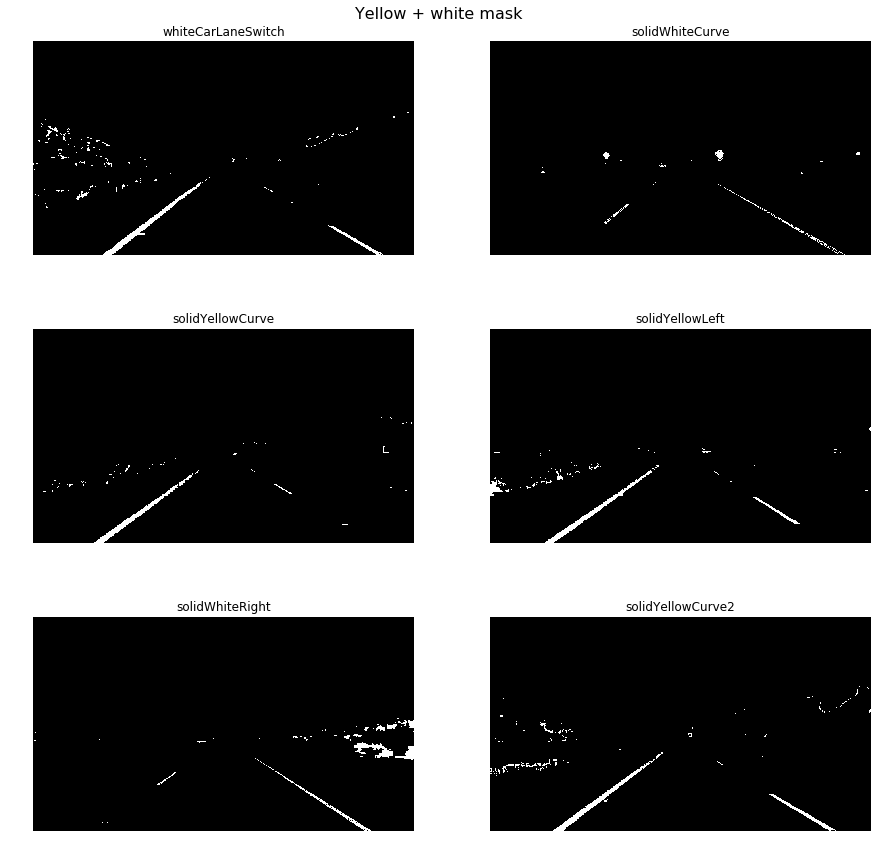

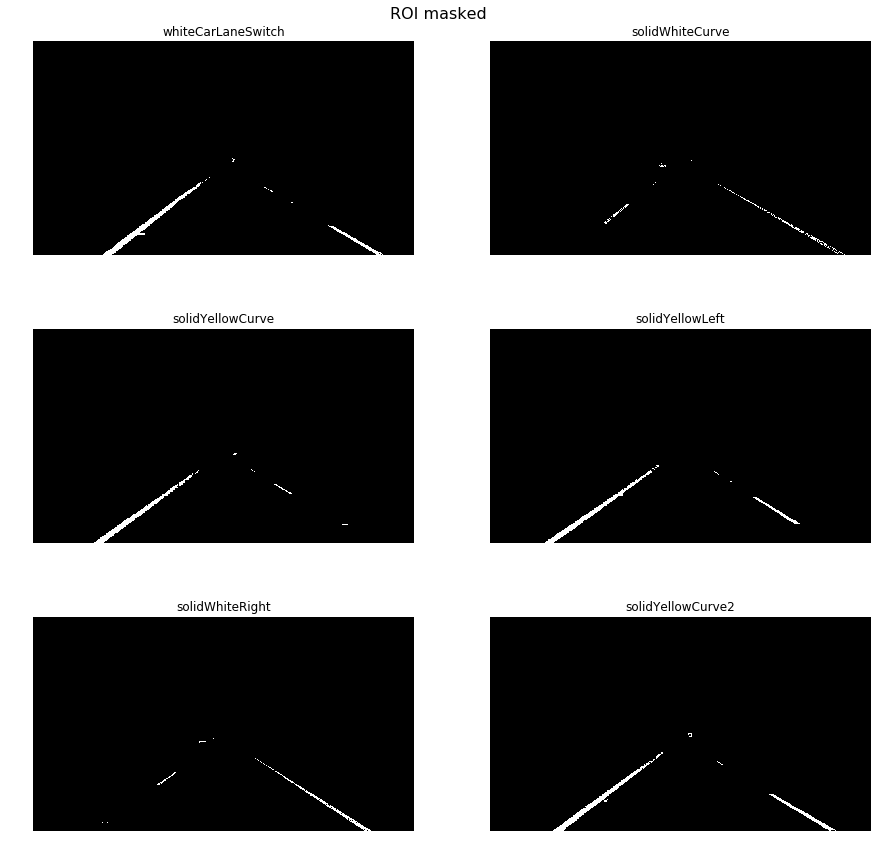

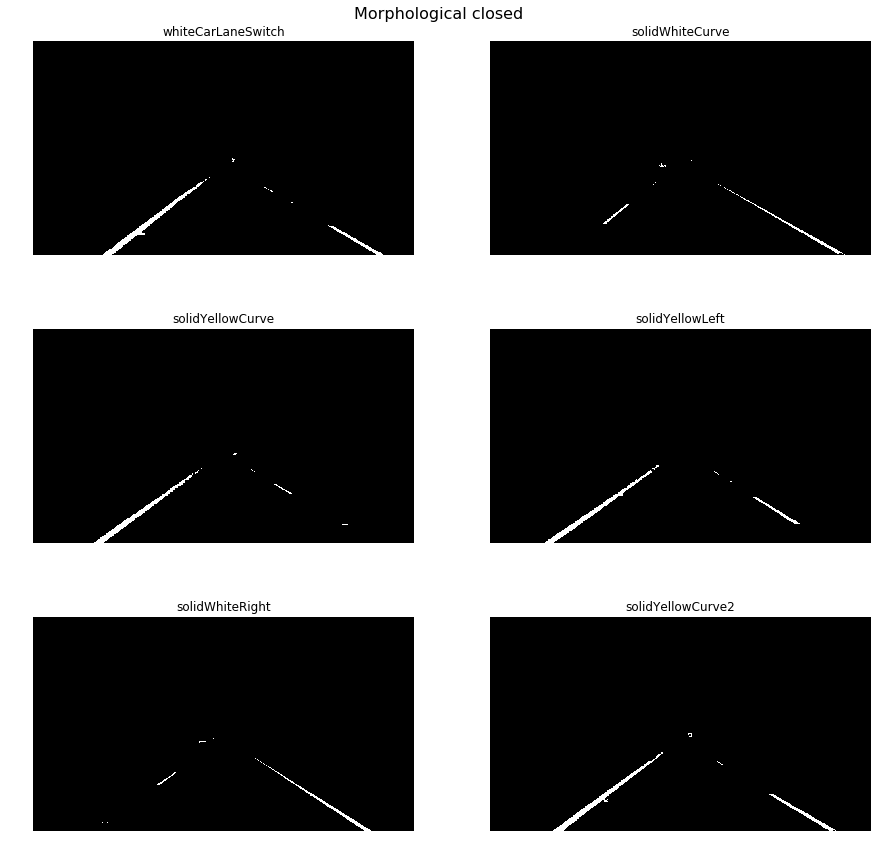

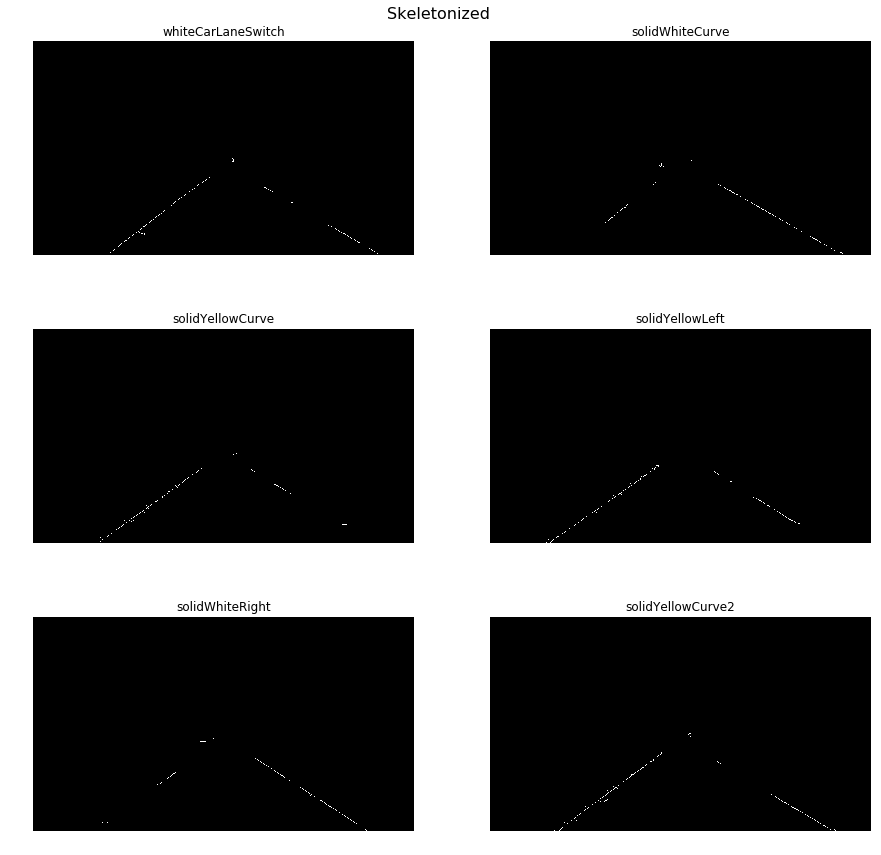

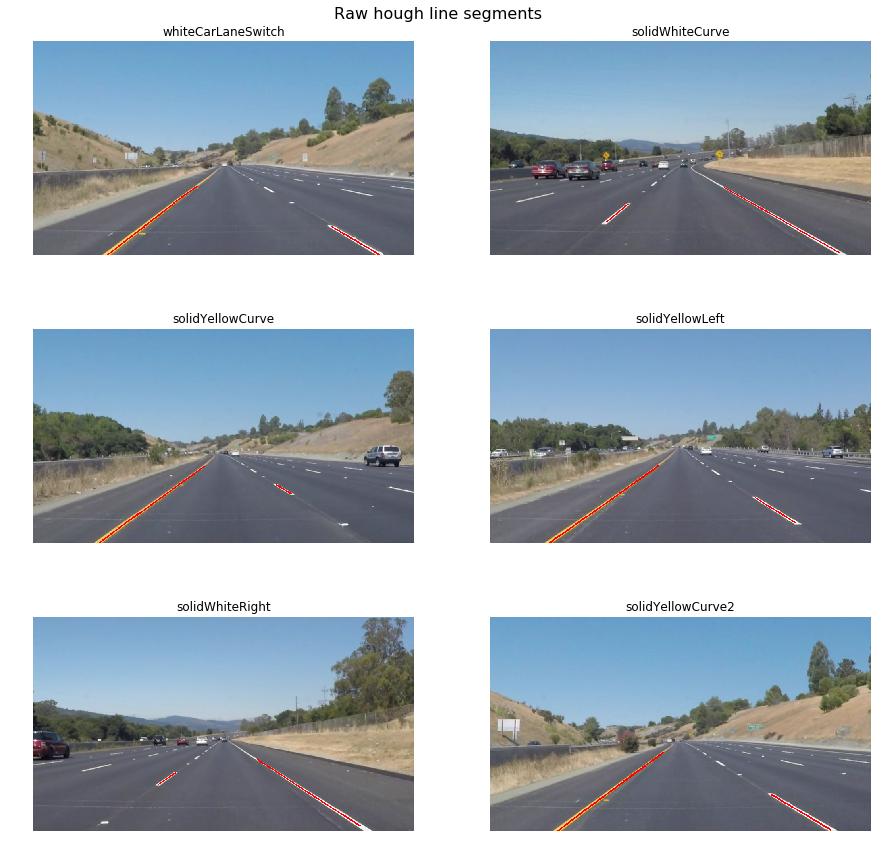

In [9]:
# Show the steps in the color based raw line segments extraction
demo_color_lines = []
for image in demo_images:
    demo_color_lines.append(find_lines_by_colors(image))

### Group togheter similar lines
Look at raw line segments slope and y-axis interception to figure out which segments belong togheter.


In [10]:
def calc_slopes(lines):
    slopes = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            slopes.append((y2 - y1) / (x2 - x1))

    return np.array(slopes)


def calc_intercepts(lines, slopes):
    intercepts = []
    for line, slope in zip(lines, slopes):
        for x1, y1, x2, y2 in line:
            intercepts.append(y1 - slope * x1)

    return np.array(intercepts)


def calc_lengths(lines):
    lengths = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            lengths.append(math.sqrt(math.pow(y1 - y2, 2) + math.pow(x1 - x2, 2)))

    return np.array(lengths)


def extract_coords(lines):
    x1_coords = []
    x2_coords = []
    y1_coords = []
    y2_coords = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            x1_coords.append(x1)
            y1_coords.append(y1)
            x2_coords.append(x2)
            y2_coords.append(y2)

    return np.array(x1_coords), np.array(y1_coords), np.array(x2_coords), np.array(y2_coords)

class LinesData:
    def __init__(self, lines, slopes=None, intercepts=None):
        self.lines = lines
        if slopes is None:
            self.slopes = calc_slopes(self.lines)
        else:
            self.slopes = slopes
        if intercepts is None:
            self.intercepts = calc_intercepts(self.lines, self.slopes)
        else:
            self.intercepts = intercepts

    def reorder(self, new_indices):
        self.lines = self.lines[new_indices]
        self.slopes = self.slopes[new_indices]
        self.intercepts = self.intercepts[new_indices]


# Group together lines that have similar slope and y-axis intercept
def find_similar_lines(lines_data):
    # Find the two slope ranges that seems to be most frequent. The assumption will be that they belong to left and
    # right lane line. The lengths of the lines are used as weights to not benefit noisy line detections.
    hist, bin_edges = np.histogram(lines_data.slopes, bins=50, range=(-5.0, 5.0),
                                   weights=calc_lengths(lines_data.lines))
    sorted_hist_indices = np.argsort(hist)[::-1]

    # For now, only find the two most similar groups of lines
    num_lines_to_find = 2
    similar_lines = []
    for idx in range(num_lines_to_find):
        if hist[sorted_hist_indices[idx]] == 0:
            # No more lines to find
            break
        slope_range = (bin_edges[sorted_hist_indices[idx]], bin_edges[sorted_hist_indices[idx] + 1])

        # Gather all lines with expected slopes
        indices = np.where(np.logical_and(lines_data.slopes >= slope_range[0],
                                          lines_data.slopes < slope_range[1]))[0]
        # Remove lines that not have the same intercept (with some tolerance)
        max_intercept_deviation = 70.0
        median_intercept = np.median(lines_data.intercepts[indices])
        intercept_range = [median_intercept - max_intercept_deviation,
                           median_intercept + max_intercept_deviation]

        indices = indices[np.where(np.logical_and(lines_data.intercepts[indices] >= intercept_range[0],
                                                  lines_data.intercepts[indices] <= intercept_range[1]))]

        # Quick fix for a bug where there sometimes are no lines near median intercept value.
        # It would have been better to use histogram also for the intercept values.
        if len(indices) > 0:
            similar_lines.append(LinesData(lines=lines_data.lines[indices],
                                           slopes=lines_data.slopes[indices],
                                           intercepts=lines_data.intercepts[indices]))
    return similar_lines

#### Demo

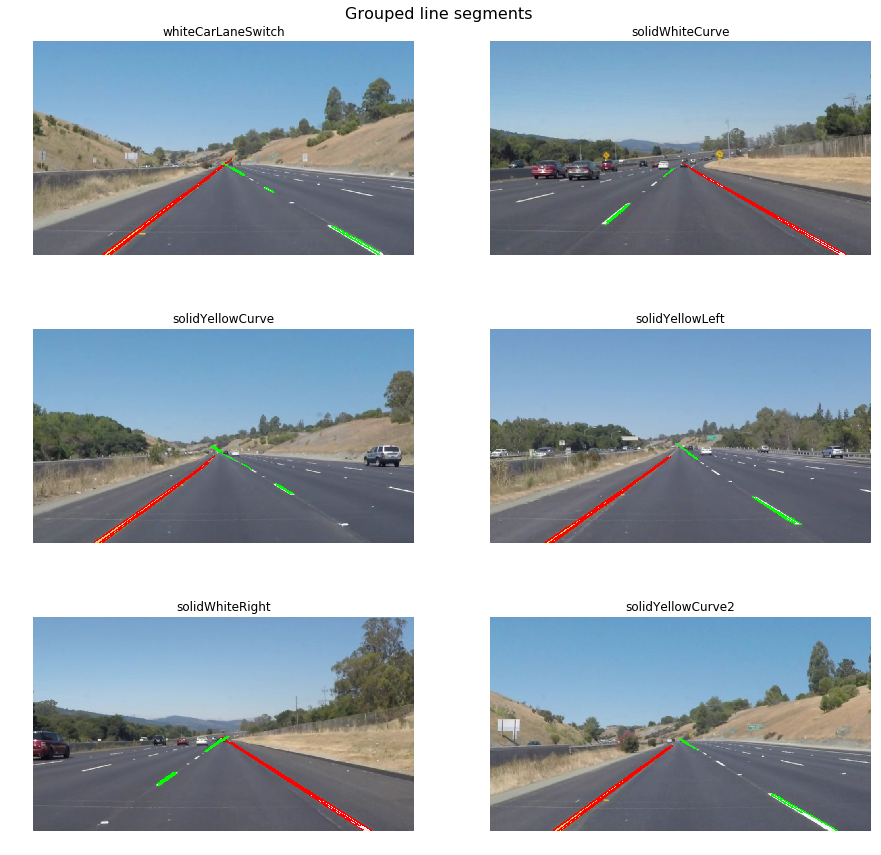

In [11]:
# Show the steps in the grouping of the detected raw line segments

demo_similar_lines_lists = []
for image, edge_lines, color_lines in zip(demo_images, demo_edge_lines, demo_color_lines):

    # Combine the output from the raw line extractions above.
    raw_line_segments = np.concatenate((edge_lines, color_lines), axis=0)

    # Calculate slope and y-axis interception.
    lines_data = LinesData(raw_line_segments)

    # Group similar lines.
    similar_lines_list = find_similar_lines(lines_data)
    
    # show the result
    plt_image = np.copy(image)  # Create a copy that can be modified before imshow 
    colors = [[255, 0, 0], [0, 255, 0]]
    for color_idx, similar_lines in enumerate(similar_lines_list):
        draw_lines(plt_image, similar_lines.lines, color=colors[color_idx], thickness=2)
    
    demo_show(plt_image, title="Grouped line segments")
    demo_similar_lines_lists.append(similar_lines_list) # Save result for later demo
    

### Find average lines from groups of line segments

In [12]:
def calc_average_line(lines_data):
    # Start with line closest to camera (largest y-coordinate), assuming they are the most accurate,
    # and that they at least should be included in average.

    # Sort lines by bottom y-coordinate
    _, y1_coords, _, y2_coords = extract_coords(lines_data.lines)
    bottom_y_coords = np.where(y1_coords >= y2_coords, y1_coords, y2_coords)
    sorted_indices = np.argsort(bottom_y_coords)[::-1]
    lines_data.reorder(sorted_indices)

    max_slope_deviation = 0.1  # Allowed deviation from current average
    max_intercept_deviation = 20  # Allowed deviation from current average
    average_slope = lines_data.slopes[0]
    average_intercept = lines_data.intercepts[0]
    average_count = 0  # Don't count the above initialization
    bottom_y = 0
    top_y = np.inf
    right_x = 0
    left_x = np.inf

    for line, slope, intercept in zip(lines_data.lines, lines_data.slopes, lines_data.intercepts):
        if (slope >= (average_slope - max_slope_deviation) and
            slope <= (average_slope + max_slope_deviation) and
            intercept >= (average_intercept - max_intercept_deviation) and
            intercept <= (average_intercept + max_intercept_deviation)):

            average_slope = ((average_slope * average_count) + slope) / (average_count + 1)
            average_intercept = ((average_intercept * average_count) + intercept) / (average_count + 1)
            average_count += 1

            # Find extreme coordinates of lines that are within max allowed deviation
            for x1, y1, x2, y2 in line:
                bottom_y = max(bottom_y, y1, y2)
                top_y = min(top_y, y1, y2)
                right_x = max(right_x, x1, x2)
                left_x = min(left_x, x1, x2)

    # Use average slope and intercept to calculate a line from bottom_y to top_y
    if average_slope < 0.0001 and average_slope > -0.0001:
        # Horizontal line, this is somewhat unexpected but lets output the line anyway
        average_x1 = left_x
        average_x2 = right_x
    else:
        average_x1 = (bottom_y - average_intercept) / average_slope
        average_x2 = (top_y - average_intercept) / average_slope

    average_y1 = bottom_y
    average_y2 = top_y

    return np.round([[[average_x1, average_y1, average_x2, average_y2]]]).astype(int)


#### Demo

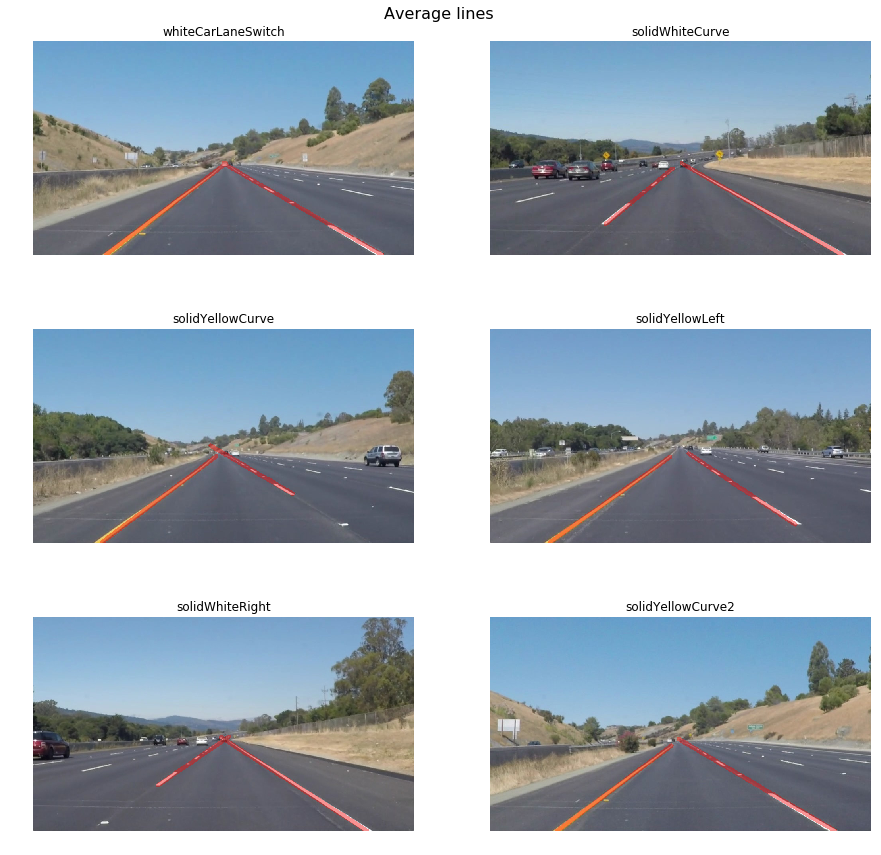

In [13]:
for image, similar_lines_list in zip(demo_images, demo_similar_lines_lists):
    plt_image = np.copy(image)  # Create a copy that can be modified before imshow 
    overlay = np.copy(image)
    for similar_lines in similar_lines_list:
        average_line = calc_average_line(similar_lines)
        draw_lines(overlay, average_line, color=[255, 0, 0], thickness=10)
    alpha = 0.4
    cv2.addWeighted(overlay, alpha, plt_image, 1 - alpha, 0, plt_image)
    demo_show(plt_image, title="Average lines")    

### Main processing loop

In [14]:
def calc_lane_lines(lines):
    allLines = LinesData(lines)
    similar_lines = find_similar_lines(allLines)

    lane_lines = []
    for line in similar_lines:
        lane_lines.append(calc_average_line(line))

    return lane_lines


def process_image(image):
    all_lines = None
    result = np.copy(image)
    overlay = np.copy(image)

    edge_lines = find_lines_by_edges(image)
    if edge_lines is not None:
        all_lines = edge_lines

    color_lines = find_lines_by_colors(image)
    if color_lines is not None:
        if all_lines is not None:
            all_lines = np.concatenate((all_lines, color_lines), axis=0)
        else:
            all_lines = color_lines

    lane_lines = calc_lane_lines(all_lines)
    for line in lane_lines:
        draw_lines(overlay, line, color=[255, 0, 0], thickness=10)

    alpha = 0.4
    cv2.addWeighted(overlay, alpha, result, 1 - alpha, 0, result)

    return result
  
        
def process_video_files():
    # Import everything needed to edit/save/watch video clips
    from moviepy.editor import VideoFileClip

    output_file_name = 'test_videos_output/solidWhiteRight.mp4'
    clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
    clip = clip1.fl_image(process_image)
    clip.write_videofile(output_file_name, audio=False)

    output_file_name = 'test_videos_output/solidYellowLeft.mp4'
    clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
    clip = clip1.fl_image(process_image)
    clip.write_videofile(output_file_name, audio=False)

    output_file_name = 'test_videos_output/challenge.mp4'
    clip1 = VideoFileClip("test_videos/challenge.mp4")
    clip = clip1.fl_image(process_image)
    clip.write_videofile(output_file_name, audio=False)

demo_mode = False  # Disable demo_mode before running the full algorithm.
process_video_files()

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 30.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:23<00:00, 28.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:16<00:00, 17.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 



In [15]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_videos_output/solidWhiteRight.mp4'))

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_videos_output/solidYellowLeft.mp4'))

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_videos_output/challenge.mp4'))